# PID codes

0 - not b tagged

1 - b tagged

13 - muon

14 - neutrino

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Helper Functions

In [49]:
def decode_line(line, varying_mass):
    """ Decode line in text file to momentum and other kinematic information of interest """
    
    if varying_mass:
        step = 7
    else:
        step = 6
    
    # Kinematic info to extract stored in lists
    pTs = []
    etas = []
    phis = []
    ms = []
    PIDs = []

    lepton = []
    neutrino = []
    
    if varying_mass:
        topmass=float(line.split()[6])
    else:
        topmass = -1
    
    for k in range(int(len(line.split())/step)):
        pT = float(line.split()[k*step+1])
        eta = float(line.split()[k*step+2])
        phi = float(line.split()[k*step+3])
        m = float(line.split()[k*step+4])
        PID = int(line.split()[k*step+5])

        pTs+=[pT]
        etas+=[eta]
        phis+=[phi]
        ms+=[m]
        if (k==1):
            PIDs+=[14]
            neutrino = [pT,eta,phi,m]
        elif (PID==13):
            PIDs+=[PID]
            lepton = [pT,eta,phi,m]
        else:
            PIDs+=[PID]
        pass
    
    return pTs, etas, phis, ms, PIDs, neutrino, lepton, topmass

In [50]:
def p4_from_ptetaphim(jet):
    """ Convert from (pT, eta, phi, mass) to (px, py, pz, pE) """
    pT, eta, phi, m = jet
    
    px = pT*np.cos( phi)
    py = pT*np.sin( phi)
    pz = pT*np.sinh(eta)
    pE = (m**2 + (pT*np.cosh(eta))**2)**0.5
    
    return [px, py, pz, pE]

def jet_mass(jet_list):
    """ Calculate the jet mass given a list of 4-vectors
    Arg:
        - jet_list (list): List of 4-vectors with format (pT, eta, phi, mass) 
    Returns:
        - jet mass (scalar)
    """
    # Convert from (pT, eta, phi, mass) to (px, py, pz, pE)
    p4_jets = [p4_from_ptetaphim(jet) for jet in jet_list]
    # Sum each component
    px, py, pz, pE = [sum(p_i) for p_i in zip(*p4_jets)]
    # Calculate jet mass
    mass = (pE**2-px**2-py**2-pz**2)**0.5
    return mass

In [51]:
def select_jets(pTs, etas, phis, ms, PIDs, lepton):
    """ Selects the leptonic and hadronic b-jets and the two hadronic jets from the W decay 
    Args:
        - pTs (list): List of pT for each jet in the event
        - etas (list): List of eta for each jet in the event
        - phis (list): List of phi for each jet in the event
        - ms (list): List of the mass for each jet in the event
        - PIDs (list): List of PID for each jet in the event
        - lepton (list): lepton 4-vector (pT, eta, phi, m)
        
    Returns:
        4-vectors for [leptonbjet, hadronicbjet, wjet1, wjet2] with format (pT, eta, phi, m)
    
    """
    
    leptonbjet = []
    wjet1 = []
    wjet2 = []
    hadronicbjet = []
    
    #First, find the b-jet closest to the lepton.
    dRmin = 999.
    whichbjet = -1
    for k in range(len(pTs)):
        if (PIDs[k] != 1):
            continue
        #print(lepton[1],etas[k])
        dR = ((lepton[1]-etas[k])**2+(lepton[2]-phis[k])**2)*0.5
        if (dR < dRmin):
            dRmin = dR
            whichbjet = k
            pass
        pass

    #Now, let's take the other leading b jet as the second b jet.
    pTmax = -1
    whichbjet2 = -1
    for k in range(len(pTs)):
        if (PIDs[k] != 1):
            continue
        if (whichbjet==k):
            continue
        if (pTs[k] > pTmax):
            pTmax = pTs[k]
            whichbjet2 = k
            pass
        pass

    #Now, let's take the remaining jets and find the pair closest to the W mass.
    w1 = -1
    w2 = -1
    dmW = 999.
    for k in range(len(pTs)):
        if (PIDs[k] != 0): # only look at non-b-tagged jets
            continue
        for k2 in range(k+1, len(pTs)):
            if (PIDs[k2] != 0): # only look at non-b-tagged jets
                continue
                
            mJJ = jet_mass([[pTs[k], etas[k], phis[k], ms[k]], [pTs[k2], etas[k2], phis[k2], ms[k2]]])
            if (abs(mJJ - 80.4) < dmW):
                dmW = abs(mJJ - 80.4)
                w1 = k
                w2 = k2
                pass
            pass
        pass

    if (whichbjet < 0 or whichbjet2 < 0 or w1 < -1 or w2 < -1 or dRmin < 0.4 or dmW>10):
#         print("Raising error in select_jets(...)")
        raise ValueError("Error in select jets (whichbjet = {}) < 0 or (whichbjet2 = {}) < 0 or (w1 = {}) < -1 or (w2 = {}) < -1 or (dRmin = {}) < 0.4".format(whichbjet, whichbjet2, w1, w2, dRmin))
    else:
        leptonbjet = [pTs[whichbjet],etas[whichbjet],phis[whichbjet],ms[whichbjet]]
        hadronicbjet = [pTs[whichbjet2],etas[whichbjet2],phis[whichbjet2],ms[whichbjet2]]
        wjet1 = [pTs[w1],etas[w1],phis[w1],ms[w1]]
        wjet2 = [pTs[w2],etas[w2],phis[w2],ms[w2]]
        return leptonbjet, hadronicbjet, wjet1, wjet2


In [52]:
def solve_for_neutrino_pz(lepton, neutrino):
    """ Solve for neutrino p_z and correct the eta value. 
    It's identically set to zero in .txt file (because it's estimated from missing pT?)
    This calculates the right value and updates the neutrino eta value. 
    """
    #solve for neutrino pz
    #mW^2 = 2(pl*pv - pzl*pzv - pTl*pTv)
    #     = 2(pl*sqrt(pTv^2 + pzv^2) - pzl*pzv - pxl*pxv - pyl*pyv)
    pl = lepton[0]*np.cosh(lepton[1])
    plz = lepton[0]*np.sinh(lepton[1])
    plx = lepton[0]*np.cos(lepton[2])
    ply = lepton[0]*np.sin(lepton[2])
    pvx = neutrino[0]*np.cos(neutrino[2])
    pvy = neutrino[0]*np.sin(neutrino[2])
    a = (plz**2-pl**2)
    b = (80.4**2+2.*(plx*pvx + ply*pvy))*plz
    c = (80.4**2/2. + plx*pvx + ply*pvy)**2 - pl**2*neutrino[0]**2
    pz = 0.
    if (b**2-4*a*c > 0):
        pz = (-b + (b**2-4*a*c)**0.5)/(2.*a)
        if (abs((-b - (b**2-4*a*c)**0.5)/(2.*a)) < pz):
            pz = (-b - (b**2-4*a*c)**0.5)/(2.*a)
            pass
        pass
    eta = np.arcsinh(pz/neutrino[0])
    neutrino[1] = eta
#     pv = neutrino[0]*np.cosh(neutrino[1])
#     pvz = neutrino[0]*np.sinh(neutrino[1])
#     print("check",np.sqrt(2.*(pl*pv - plz*pvz - plx*pvx - ply*pvy)))

In [67]:
def read_file(filename, varying_mass, cutoff = None):
    succeed = 0
    failed = 0
    events = []
    selection_mask = [] # keep track of which events we are selecting to match particle level to detector level data
    with open(filename) as f:
        mycounter = 0
        for line in f:
            event = {}
            mycounter+=1
            if (mycounter > (cutoff if cutoff is not None else 1e20)):
                break
            if (mycounter%10000==0):
                print("   ", mycounter)
                print("succeed = ", succeed, ". failed = ", failed, flush = True)

            # Decode line
            pTs, etas, phis, ms, PIDs, neutrino, lepton, topmass = decode_line(line, varying_mass = varying_mass)
            
            event['pTs'] = pTs
            event['etas'] = etas
            event['phis'] = phis
            event['ms'] = ms
            event['PIDs'] = PIDs
            
            # Get subjets
            try:
                leptonbjet, hadronicbjet, wjet1, wjet2 = select_jets(pTs, etas, phis, ms, PIDs, lepton)
                succeed +=1
                selection_mask.append(True)
            except:
                
                # Catch error from selection of jets
#                 print(err)
                failed+=1
                selection_mask.append(False)
                events.append(event)
                continue
            # Correct neutrino momentum
            solve_for_neutrino_pz(lepton, neutrino)

            # Calculate W-mass
            mW = jet_mass([wjet1, wjet2]) 

            # Hadronic top mass
            mt_had = jet_mass([hadronicbjet, wjet1, wjet2])* 80.4/mW # NOTE: Applying w-mass calibration

            # Leptonic top mass
            mt_lep = jet_mass([leptonbjet, lepton, neutrino])

            # Leptonic W mass 
            #mW_lep = jet_mass([lepton, neutrino])
     
            event['neutrino'] = neutrino          # (pT, eta, phi, m)
            event['lepton'] = lepton              # (pT, eta, phi, m)
            
            event['leptonbjet'] = leptonbjet      # (pT, eta, phi, m)
            event['hadronicbjet'] = hadronicbjet  # (pT, eta, phi, m)
            event['wjet1'] = wjet1                # (pT, eta, phi, m)
            event['wjet2'] = wjet2                # (pT, eta, phi, m)
            
            event['mW'] = mW
            event['mt_had'] = mt_had
            event['mt_lep'] = mt_lep
            event['mt_MC'] = topmass
            
            events.append(event)
            #break
                        
    return events, selection_mask

# Varying Mass Data

In [ ]:
part_events, part_mask = read_file("/data1/users/bpnachman/DCTRFitting/output_part_varmass.txt", varying_mass=True, cutoff=None)
det_events,  det_mask  = read_file("/data1/users/bpnachman/DCTRFitting/output_det_varmass.txt",  varying_mass=True, cutoff=None)

    10000
succeed =  3541 . failed =  6458
    20000
succeed =  7029 . failed =  12970
    30000
succeed =  10563 . failed =  19436
    40000
succeed =  14157 . failed =  25842
    50000
succeed =  17769 . failed =  32230
    60000
succeed =  21358 . failed =  38641
    70000
succeed =  24921 . failed =  45078
    80000
succeed =  28454 . failed =  51545
    90000
succeed =  31945 . failed =  58054
    100000
succeed =  35542 . failed =  64457
    110000
succeed =  39129 . failed =  70870
    120000
succeed =  42780 . failed =  77219
    130000
succeed =  46338 . failed =  83661
    140000
succeed =  49821 . failed =  90178
    150000
succeed =  53340 . failed =  96659
    160000
succeed =  56886 . failed =  103113
    170000
succeed =  60461 . failed =  109538
    180000
succeed =  63990 . failed =  116009
    190000
succeed =  67565 . failed =  122434
    200000
succeed =  71101 . failed =  128898
    210000
succeed =  74676 . failed =  135323
    220000
succeed =  78165 . failed =  

    1720000
succeed =  608940 . failed =  1111059
    1730000
succeed =  612510 . failed =  1117489
    1740000
succeed =  616125 . failed =  1123874
    1750000
succeed =  619720 . failed =  1130279
    1760000
succeed =  623297 . failed =  1136702
    1770000
succeed =  626844 . failed =  1143155
    1780000
succeed =  630372 . failed =  1149627
    1790000
succeed =  633819 . failed =  1156180
    1800000
succeed =  637393 . failed =  1162606
    1810000
succeed =  640962 . failed =  1169037
    1820000
succeed =  644513 . failed =  1175486
    1830000
succeed =  648039 . failed =  1181960
    1840000
succeed =  651523 . failed =  1188476
    1850000
succeed =  654994 . failed =  1195005
    1860000
succeed =  658589 . failed =  1201410
    1870000
succeed =  662157 . failed =  1207842
    1880000
succeed =  665658 . failed =  1214341
    1890000
succeed =  669153 . failed =  1220846
    1900000
succeed =  672662 . failed =  1227337
    1910000
succeed =  676212 . failed =  1233787


    3350000
succeed =  1186343 . failed =  2163656
    3360000
succeed =  1189880 . failed =  2170119
    3370000
succeed =  1193376 . failed =  2176623
    3380000
succeed =  1196974 . failed =  2183025
    3390000
succeed =  1200524 . failed =  2189475
    3400000
succeed =  1204024 . failed =  2195975
    3410000
succeed =  1207529 . failed =  2202470
    3420000
succeed =  1211050 . failed =  2208949
    3430000
succeed =  1214623 . failed =  2215376
    3440000
succeed =  1218198 . failed =  2221801
    3450000
succeed =  1221788 . failed =  2228211
    3460000
succeed =  1225319 . failed =  2234680
    3470000
succeed =  1228802 . failed =  2241197
    3480000
succeed =  1232366 . failed =  2247633
    3490000
succeed =  1235877 . failed =  2254122
    3500000
succeed =  1239461 . failed =  2260538
    3510000
succeed =  1243046 . failed =  2266953
    3520000
succeed =  1246582 . failed =  2273417
    3530000
succeed =  1250103 . failed =  2279896
    3540000
succeed =  1253627 

    4960000
succeed =  1756634 . failed =  3203365
    4970000
succeed =  1760170 . failed =  3209829
    4980000
succeed =  1763641 . failed =  3216358
    4990000
succeed =  1767147 . failed =  3222852
    5000000
succeed =  1770691 . failed =  3229308
    10000
succeed =  763 . failed =  9236
    20000
succeed =  1530 . failed =  18469
    30000
succeed =  2305 . failed =  27694
    40000
succeed =  3057 . failed =  36942
    50000
succeed =  3898 . failed =  46101
    60000
succeed =  4666 . failed =  55333
    70000
succeed =  5412 . failed =  64587
    80000
succeed =  6146 . failed =  73853
    90000
succeed =  6887 . failed =  83112
    100000
succeed =  7665 . failed =  92334
    110000
succeed =  8414 . failed =  101585
    120000
succeed =  9216 . failed =  110783
    130000
succeed =  9949 . failed =  120050
    140000
succeed =  10715 . failed =  129284
    150000
succeed =  11493 . failed =  138506
    160000
succeed =  12261 . failed =  147738
    170000
succeed =  13085

In [83]:
np.savez('varmass.npz', part_events = part_events, 
                        det_events  = det_events,
                        part_mask   = part_mask,
                        det_mask    = det_mask
        )

# Fixed Mass

In [86]:
part_events, part_mask = read_file("/data1/users/bpnachman/DCTRFitting/output_part_175_0.txt", varying_mass=False, cutoff=None)
det_events,  det_mask  = read_file("/data1/users/bpnachman/DCTRFitting/output_det_175_0.txt",  varying_mass=False, cutoff=None)


    10000
succeed =  3520 . failed =  6479
    20000
succeed =  7027 . failed =  12972
    30000
succeed =  10618 . failed =  19381
    40000
succeed =  14209 . failed =  25790
    50000
succeed =  17840 . failed =  32159
    60000
succeed =  21329 . failed =  38670
    70000
succeed =  24844 . failed =  45155
    80000
succeed =  28509 . failed =  51490
    90000
succeed =  32154 . failed =  57845
    100000
succeed =  35672 . failed =  64327
    110000
succeed =  39226 . failed =  70773
    120000
succeed =  42813 . failed =  77186
    130000
succeed =  46355 . failed =  83644
    140000
succeed =  49900 . failed =  90099
    150000
succeed =  53409 . failed =  96590
    160000
succeed =  57042 . failed =  102957
    170000
succeed =  60600 . failed =  109399
    180000
succeed =  64258 . failed =  115741
    190000
succeed =  67789 . failed =  122210
    200000
succeed =  71368 . failed =  128631
    210000
succeed =  74900 . failed =  135099
    220000
succeed =  78423 . failed =  

    760000
succeed =  58351 . failed =  701648
    770000
succeed =  59150 . failed =  710849
    780000
succeed =  59914 . failed =  720085
    790000
succeed =  60662 . failed =  729337
    800000
succeed =  61370 . failed =  738629
    810000
succeed =  62185 . failed =  747814
    820000
succeed =  62960 . failed =  757039
    830000
succeed =  63690 . failed =  766309
    840000
succeed =  64426 . failed =  775573
    850000
succeed =  65271 . failed =  784728
    860000
succeed =  66043 . failed =  793956
    870000
succeed =  66777 . failed =  803222
    880000
succeed =  67559 . failed =  812440
    890000
succeed =  68364 . failed =  821635
    900000
succeed =  69129 . failed =  830870
    910000
succeed =  69891 . failed =  840108
    920000
succeed =  70682 . failed =  849317
    930000
succeed =  71457 . failed =  858542
    940000
succeed =  72194 . failed =  867805
    950000
succeed =  72986 . failed =  877013
    960000
succeed =  73736 . failed =  886263
    970000
su

In [88]:
# np.savez('top_175_0.npz', part_events = part_events, 
#                         det_events  = det_events,
#                         part_mask   = part_mask,
#                         det_mask    = det_mask
#         )

# Process npz files

In [3]:
import numpy as np
# data = np.load('top_172_5.npz', allow_pickle = True)
data = np.load('DCTRFitting/top_175_0.npz', allow_pickle = True)
# data = np.load('varmass.npz', allow_pickle = True)

In [4]:
part_events = data['part_events']
det_events  = data['det_events']
part_mask   = data['part_mask']
det_mask    = data['det_mask']

In [11]:
part_events[2]

{'PIDs': [13, 14, 0, 1, 0, 1, 0],
 'etas': [-1.07495, 0.0, -1.07734, -1.8462, 0.345575, -1.33324, -2.11259],
 'hadronicbjet': [80.2864, -1.8462, 3.03306, 9.00043],
 'lepton': [116.379, -1.07495, -0.211618, 0.1],
 'leptonbjet': [24.7869, -1.33324, 2.80358, 4.96514],
 'mW': 74.28451586179503,
 'ms': [0.1, 0.0, 5.10741, 9.00043, 7.15531, 4.96514, 7.7357],
 'mt_MC': -1,
 'mt_had': 162.76291676376403,
 'mt_lep': 150.47883672786605,
 'neutrino': [56.2531, -1.554708497701711, 0.685825, 0.0],
 'pTs': [116.379, 56.2531, 117.764, 80.2864, 24.9718, 24.7869, 21.263],
 'phis': [-0.211618,
  0.685825,
  -0.213448,
  3.03306,
  -2.61482,
  2.80358,
  -2.36768],
 'wjet1': [24.9718, 0.345575, -2.61482, 7.15531],
 'wjet2': [21.263, -2.11259, -2.36768, 7.7357]}

## All jets in event

In [104]:
# particle_alljets = []
# detector_alljets = []

# for part_event, det_event, dmask, pmask in zip(part_events, det_events, det_mask, part_mask):
#     # Only select events that passed the cuts at both particle and detector level
#     if (dmask ==  True) and (pmask == True):
#         if part_event['mt_MC'] == -1:
#             mtop = np.random.uniform(170, 180)
#         else:
#             mtop = part_event['mt_MC']
            
#         particle_alljets.append(np.stack((part_event['pTs'],
#                                        part_event['etas'],
#                                        part_event['phis'],
#                                        part_event['ms'],
#                                        part_event['PIDs'],
#                                        mtop*np.ones_like(part_event['PIDs'])
#                                      )).T)
#         detector_alljets.append(np.stack((det_event['pTs'],
#                                        det_event['etas'],
#                                        det_event['phis'],
#                                        det_event['ms'],
#                                        det_event['PIDs'],
#                                        mtop*np.ones_like(det_event['PIDs'])
#                                      )).T)
#         break

## top-subjets

In [113]:
particle_6j = []
detector_6j = []
part_masses = []
det_masses = []



for part_event, det_event, dmask, pmask in zip(part_events, det_events, det_mask, part_mask):
    # Only select events that passed the cuts at both particle and detector level
    if (dmask ==  True) and (pmask == True):
        if part_event['mt_MC'] == -1:
            mtop = np.random.uniform(170, 180)
        else:
            mtop = part_event['mt_MC']
            
        particle_6j.append(np.stack((  part_event['leptonbjet']   + [mtop],
                                       part_event['hadronicbjet'] + [mtop],
                                       part_event['lepton']       + [mtop],
                                       part_event['neutrino']     + [mtop],
                                       part_event['wjet1']        + [mtop],
                                       part_event['wjet2']        + [mtop],
                                     )
                                    ))
        part_masses.append([part_event['mt_lep'], part_event['mt_had'], part_event['mW']])
        
        detector_6j.append(np.stack((  det_event['leptonbjet']   + [mtop],
                                       det_event['hadronicbjet'] + [mtop],
                                       det_event['lepton']       + [mtop],
                                       det_event['neutrino']     + [mtop],
                                       det_event['wjet1']        + [mtop],
                                       det_event['wjet2']        + [mtop],
                                     )
                                    ))
        det_masses.append([det_event['mt_lep'], det_event['mt_had'], det_event['mW']])
        
particle_6j = np.array(particle_6j)
detector_6j = np.array(detector_6j)
part_masses = np.array(part_masses)
det_masses  = np.array(det_masses)

In [114]:
print(particle_6j.shape)
print(detector_6j.shape)
print(part_masses.shape)
print(det_masses.shape)

(59119, 6, 5)
(59119, 6, 5)
(59119, 3)
(59119, 3)


In [115]:
# np.save('L', particle_6j)
# np.save('det_172_5_6j.npy', detector_6j)
# np.save('part_172_5_6j_obs.npy', part_masses)
# np.save('det_172_5_6j_obs.npy', det_masses)

# np.save('part_175_0_6j.npy', particle_6j)
# np.save('det_175_0_6j.npy', detector_6j)
# np.save('part_175_0_6j_obs.npy', part_masses)
# np.save('det_175_0_6j_obs.npy', det_masses)


# np.save('part_varmass_6j.npy', particle_6j)
# np.save('det_varmass_6j.npy', detector_6j)
# np.save('part_varmass_6j_obs.npy', part_masses)
# np.save('det_varmass_6j_obs.npy', det_masses)




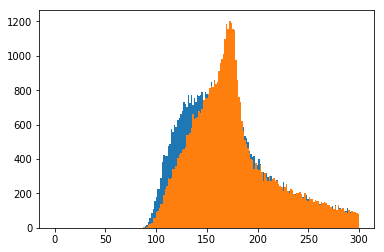

In [116]:
# plt.hist(det_masses[:,1], bins = np.linspace(0,300,200))
# plt.hist(part_masses[:,1], bins = np.linspace(0,300,200))
# plt.show()

In [4]:
sum(det_mask)/len(det_mask)

0.076791